In [1]:
DUMP_X_FILE = 'dump_X.npy'
DUMP_Y_FILE = 'dump_Y.npy'
MODELS_DIR = 'models'

LOAD_WEIGHTS = True
LOAD_OPT = True

EPOCH_COUNT = 30000
LR = 1e-3
BATCH_SIZE = 32
INIT_STD = 0.02

In [2]:
%matplotlib inline

import os

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [ ]:
if not os.path.exists('models'):
    os.mkdir('models')

In [3]:
USE_CUDA = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor

if USE_CUDA:
    print('Using CUDA')
else:
    print('Using CPU')

Using CUDA


In [4]:
def init_weights(m, verbose=False):
    if type(m) in [nn.Conv2d, nn.Linear, nn.ConvTranspose2d]:
        torch.nn.init.normal_(m.weight.data, mean=0, std=INIT_STD)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias.data, mean=0, std=INIT_STD)
    elif type(m) in [nn.BatchNorm2d, nn.LeakyReLU, nn.ReLU, nn.Sequential, nn.Tanh]:
        return
    else:
        if verbose:
            print('Couldn\'t init wieghts of layer with type:', type(m))

In [5]:
X = np.load(DUMP_X_FILE)
Y = np.load(DUMP_Y_FILE)

N = X.shape[0]

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dense_1 = nn.Linear(in_features=6572, out_features=512)
        self.dense_1_bn = nn.BatchNorm1d(512)
        self.dense_2 = nn.Linear(in_features=512, out_features=512)
        self.dense_2_bn = nn.BatchNorm1d(512)
        self.dense_3 = nn.Linear(in_features=512, out_features=512)
        self.dense_3_bn = nn.BatchNorm1d(512)

        self.us_1 = nn.Upsample(size=(5, 5))
        self.conv_1_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv_1_1_bn = nn.BatchNorm2d(512)
        self.conv_1_2 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.conv_1_2_bn = nn.BatchNorm2d(256)

        self.us_2 = nn.Upsample(size=(10, 10))
        self.conv_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv_2_1_bn = nn.BatchNorm2d(256)
        self.conv_2_2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.conv_2_2_bn = nn.BatchNorm2d(128)

        self.us_3 = nn.Upsample(size=(20, 20))
        self.conv_3_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv_3_1_bn = nn.BatchNorm2d(128)
        self.conv_3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv_3_2_bn = nn.BatchNorm2d(128)

        self.us_4 = nn.Upsample(size=(40, 40))
        self.conv_4_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv_4_1_bn = nn.BatchNorm2d(128)
        self.conv_4_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv_4_2_bn = nn.BatchNorm2d(128)

        self.us_5 = nn.Upsample(size=(80, 80))
        self.conv_5_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv_5_1_bn = nn.BatchNorm2d(128)
        self.conv_5_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv_5_2_bn = nn.BatchNorm2d(128)

        self.conv_out = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1)
        
        if USE_CUDA:
            self.cuda()
            
    def forward(self, x):
        x = F.relu(self.dense_1_bn(self.dense_1(x)))
        x = F.relu(self.dense_2_bn(self.dense_2(x)))
        x = F.relu(self.dense_3_bn(self.dense_3(x)))

        x = torch.reshape(x, (-1, 512, 1, 1))

        x = self.us_1(x)
        x = F.relu(self.conv_1_1_bn(self.conv_1_1(x)))
        x = F.relu(self.conv_1_2_bn(self.conv_1_2(x)))

        x = self.us_2(x)
        x = F.relu(self.conv_2_1_bn(self.conv_2_1(x)))
        x = F.relu(self.conv_2_2_bn(self.conv_2_2(x)))

        x = self.us_3(x)
        x = F.relu(self.conv_3_1_bn(self.conv_3_1(x)))
        x = F.relu(self.conv_3_2_bn(self.conv_3_2(x)))

        x = self.us_4(x)
        x = F.relu(self.conv_4_1_bn(self.conv_4_1(x)))
        x = F.relu(self.conv_4_2_bn(self.conv_4_2(x)))

        x = self.us_5(x)
        x = F.relu(self.conv_5_1_bn(self.conv_5_1(x)))
        x = F.relu(self.conv_5_2_bn(self.conv_5_2(x)))

        x = torch.sigmoid(self.conv_out(x))
        
        return x

In [7]:
net = Net()
net.apply(init_weights)
optimizer = optim.Adam(net.parameters(), lr=LR)
start_epoch = 0

In [8]:
if os.listdir(MODELS_DIR) != []:
    models_names = os.listdir(MODELS_DIR)
    nums = list(map(int, models_names))
    choosen_model_num = max(nums)
    choosen_model = str(choosen_model_num)

    model = torch.load(os.path.join(MODELS_DIR, choosen_model))
    if LOAD_WEIGHTS:
        net.load_state_dict(model['weights'])
    if LOAD_OPT:
        optimizer.load_state_dict(model['optim'])

    start_epoch = choosen_model_num
    
    print('Model loaded!')
else:
    print('Starting with random model')

Model loaded!



#######################################
Epoch: 570



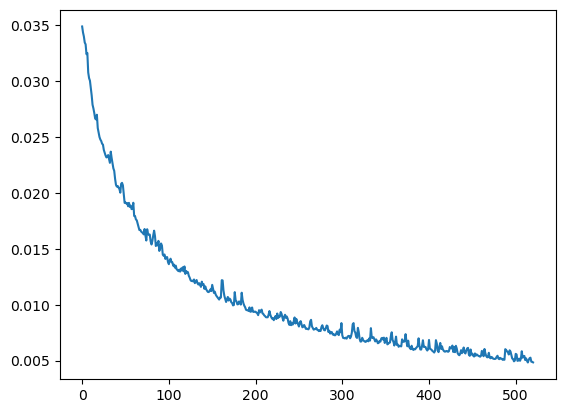


#######################################
Epoch: 571



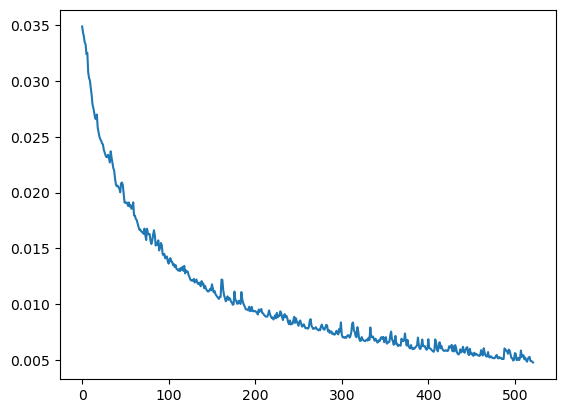


#######################################
Epoch: 572



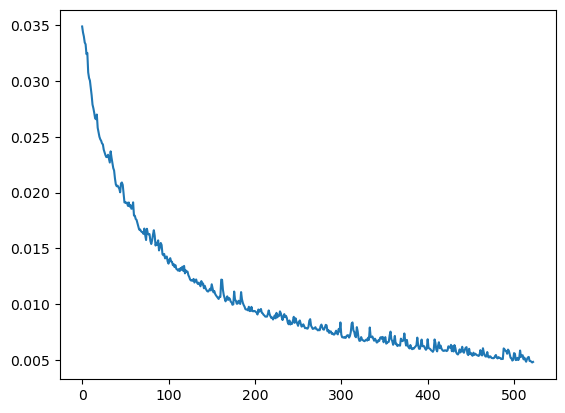


#######################################
Epoch: 573



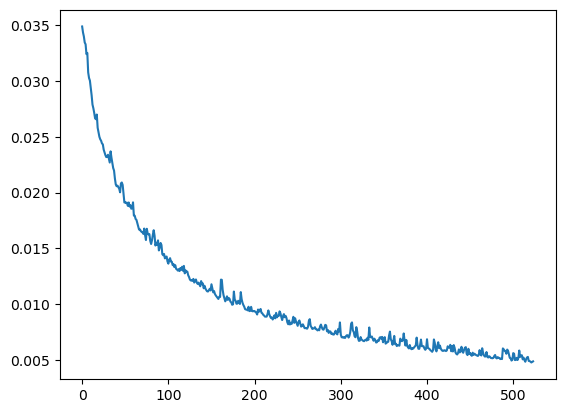


#######################################
Epoch: 574



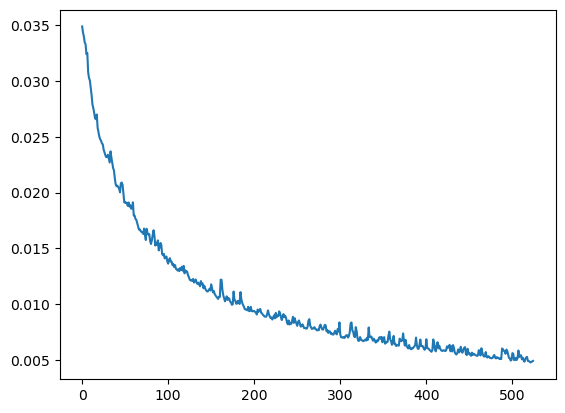


#######################################
Epoch: 575



KeyboardInterrupt: 

In [9]:
idx = [i for i in range(N)]

losses = []

for epoch_num in range(start_epoch, start_epoch + EPOCH_COUNT):
    if (epoch_num % 10 == 0):
        clear_output(wait=True)

    if (epoch_num % 50 == 0):
        torch.save({
            'weights' : net.state_dict(),
            'optim' : optimizer.state_dict()
        }, os.path.join(MODELS_DIR, str(epoch_num))
        )

    print()
    print("#######################################")
    print('Epoch:', epoch_num)
    print()

    random.shuffle(idx)
    curr_losses = []
    
    for start in range(0, N - BATCH_SIZE, BATCH_SIZE):
        batch_X = []
        batch_Y = []
        for i in range(start, start + BATCH_SIZE):
            batch_X.append(X[idx[i]])
            batch_Y.append(Y[idx[i]])

        batch_X = FloatTensor(np.array(batch_X))
        batch_Y = FloatTensor(np.array(batch_Y))

        optimizer.zero_grad()
        loss = F.mse_loss(net(batch_X)[:, 0, :, :], batch_Y, reduction='mean')
        loss.backward()
        optimizer.step()

        curr_losses.append(loss.item())

    losses.append(np.mean(curr_losses))

    plt.plot(losses)
    plt.show()
    